To classify emails as Spam or Not Spam using Support Vector Machine (SVM), a supervised machine learning algorithm for binary classification.

Labels:<br>
1: Spam <br>
0: Not Spam

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

In [52]:
df = pd.read_table(url, header=None, names=['label', 'message'])

In [53]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [54]:
df.shape

(5572, 2)

In [55]:
df.isnull().sum().sort_values(ascending=False)

label      0
message    0
dtype: int64

In [56]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [57]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [58]:
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


C:\Users\Admin\AppData\Local\Temp\ipykernel_10708\2084140217.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


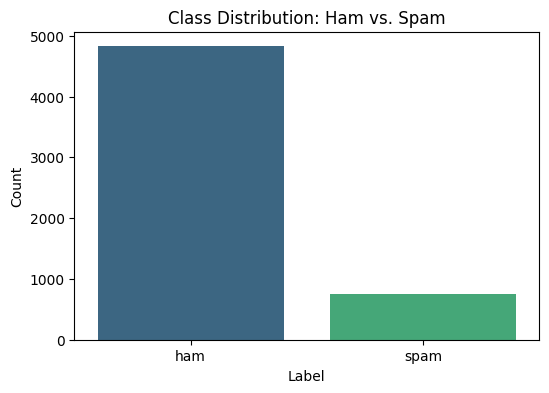

In [59]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution: Ham vs. Spam')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [64]:
from wordcloud import WordCloud

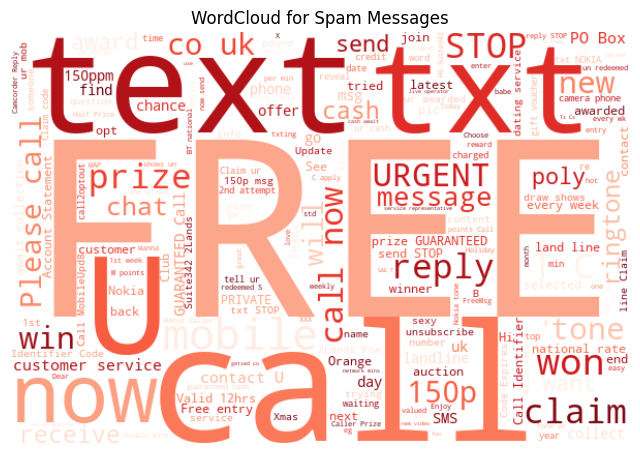

In [65]:
spam_words = ' '.join(df[df['label'] == 'spam']['message'])
spam_wc = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate(spam_words)

plt.figure(figsize=(8,6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Spam Messages')
plt.show()

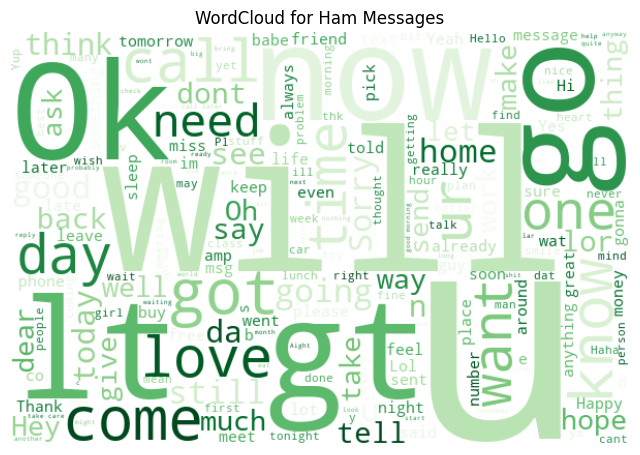

In [66]:
ham_words = ' '.join(df[df['label'] == 'ham']['message'])
ham_wc = WordCloud(width=600, height=400, background_color='white', colormap='Greens').generate(ham_words)

plt.figure(figsize=(8,6))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Ham Messages')
plt.show()

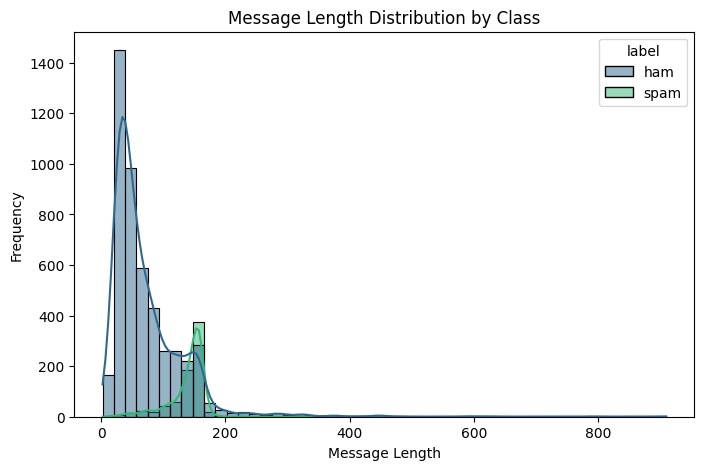

In [62]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True, palette='viridis')
plt.title('Message Length Distribution by Class')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

In [67]:
df.drop(columns=['label'], inplace=True)

In [68]:
df.head()

,message,label_num,message_length
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [70]:
X = df['message']
y = df['label_num']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

In [72]:
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

In [73]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svm',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [74]:
train_score = svm_pipeline.score(X_train, y_train)
test_score = svm_pipeline.score(X_test, y_test)

In [75]:
print(f" Pipeline training complete.\nTrain Accuracy: {train_score:.4f}\nTest Accuracy: {test_score:.4f}")

 Pipeline training complete.
Train Accuracy: 0.9978
Test Accuracy: 0.9919


In [76]:
y_pred = svm_pipeline.predict(X_test)

In [77]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

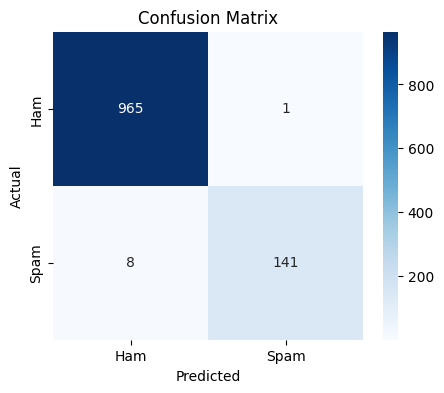

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [79]:
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


              precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       966
        Spam       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [80]:

from sklearn.model_selection import GridSearchCV
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']  # only used for rbf
}

grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\n Best Parameters found:")
print(grid_search.best_params_)

print(f"\n Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"\n Test Accuracy with Best Model: {test_score:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Best Parameters found:
{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

 Best Cross-Validation Accuracy: 0.9827

 Test Accuracy with Best Model: 0.9901


In [ ]:
import joblib

joblib.dump(best_model, 'svm_spam_model.pkl')


Model pipeline saved as svm_spam_pipeline.pkl
